In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta
import time
%cd ..
from graphs import generate_full_report, perform_profit_factor_permutation_test
from utils import MARKET_TZ, is_market_open, calculate_profit_factor
%cd earnings

f:\Coding\Trading
f:\Coding\Trading\earnings


In [2]:
def get_next_trading_day(date):
    d = date
    while True:
        d += timedelta(days=1)
        if is_market_open(d):
            return d

def get_previous_trading_day(date):
    d = date
    while True:
        d -= timedelta(days=1)
        if is_market_open(d):
            return d

In [3]:
def get_historical_data(ticker, start_date, end_date, interval, max_retries=3, backoff_factor=2):
    """
    Retrieve historical data with retry logic for rate limits.
    Returns timezone-aware DataFrame in MARKET_TZ.
    """
    os.makedirs('historical_data', exist_ok=True)
    file_path = f'historical_data/{ticker}.csv'
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    for attempt in range(max_retries + 1):
        try:
            new_data = yf.download(ticker, 
                                 start=start_date,
                                 end=end_date,
                                 interval=interval,
                                 progress=False)
            
            if not new_data.empty:
                # Process columns and timezone
                if isinstance(new_data.columns, pd.MultiIndex):
                    new_data.columns = new_data.columns.get_level_values(0)
                    
                if new_data.index.tzinfo is None:
                    new_data.index = new_data.index.tz_localize(MARKET_TZ)
                else:
                    new_data.index = new_data.index.tz_convert(MARKET_TZ)
                
                return new_data
            
            return pd.DataFrame()  # Return empty if no data
            
        except Exception as e:
            if attempt < max_retries:
                wait_time = backoff_factor ** attempt
                print(f"Retry {attempt+1}/{max_retries} for {ticker} in {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"Failed to fetch {ticker} after {max_retries} retries: {str(e)}")
                return pd.DataFrame()
    
    return pd.DataFrame()

In [4]:
def get_stock_metrics(ticker):
    """Fetch fundamental data for a ticker"""
    try:
        tk = yf.Ticker(ticker)
        info = tk.info
        
        # Basic metrics
        metrics = {
            'Symbol': ticker,
            'Sector': info.get('sector', 'Unknown'),
            'Industry': info.get('industry', 'Unknown'),
            'MarketCap': info.get('marketCap', None),
            'Beta': info.get('beta', None),
            'PE': info.get('trailingPE', None),
            'ForwardPE': info.get('forwardPE', None),
            'PEG': info.get('pegRatio', None),
            'ShortPercentFloat': info.get('shortPercentOfFloat', None),
            'AvgVolume': info.get('averageVolume', None),
        }
        
        # Calculate market cap category
        mcap = metrics['MarketCap']
        if mcap:
            if mcap >= 200e9:
                metrics['CapSize'] = 'Mega'
            elif mcap >= 10e9:
                metrics['CapSize'] = 'Large'
            elif mcap >= 2e9:
                metrics['CapSize'] = 'Mid'
            elif mcap >= 300e6:
                metrics['CapSize'] = 'Small'
            else:
                metrics['CapSize'] = 'Micro'
        else:
            metrics['CapSize'] = 'Unknown'
            
        return metrics
    except Exception as e:
        print(f"Error fetching metrics for {ticker}: {str(e)}")
        return {'Symbol': ticker, 'Sector': 'Unknown', 'Industry': 'Unknown', 
                'CapSize': 'Unknown', 'MarketCap': None}

In [5]:
def get_eps_data(ticker):
    """Fetch and normalize EPS data from yfinance."""
    try:
        tk = yf.Ticker(ticker)
        # Try to get earnings dates, handle potential API changes
        try:
            df = tk.earnings_dates
        except (AttributeError, TypeError):
            # Fallback: try to get earnings history instead
            earnings_hist = tk.earnings_history
            if earnings_hist is not None and not earnings_hist.empty:
                df = earnings_hist
            else:
                # Second fallback: try calendar earnings
                try:
                    df = tk.calendar
                except:
                    return pd.DataFrame()
        
        if df is None or df.empty:
            return pd.DataFrame()
        
        # Processing steps remain the same
        df = df.reset_index()
        
        # Handle different column naming conventions
        rename_map = {}
        for col in df.columns:
            if 'earnings' in col.lower() and 'date' in col.lower():
                rename_map[col] = 'EarningsDate'
            elif 'estimate' in col.lower():
                rename_map[col] = 'Estimate'
            elif ('reported' in col.lower() and 'eps' in col.lower()) or ('actual' in col.lower()):
                rename_map[col] = 'Actual'
            elif 'surprise' in col.lower() and '%' in col:
                rename_map[col] = 'SurprisePct'
        
        # Only rename columns that exist
        existing_cols = {k: v for k, v in rename_map.items() if k in df.columns}
        if existing_cols:
            df = df.rename(columns=existing_cols)
        
        # Ensure required columns exist
        required_cols = ['EarningsDate', 'Estimate', 'Actual']
        if not all(col in df.columns for col in required_cols):
            return pd.DataFrame()
        
        # Parse dates
        if 'EarningsDate' in df.columns:
            df['EarningsDate'] = pd.to_datetime(df['EarningsDate']).dt.tz_localize(None).dt.date
        
        # Drop rows with missing data
        df = df.dropna(subset=['Estimate', 'Actual'])
        
        # Calculate SurprisePct if missing
        if 'SurprisePct' not in df.columns or df['SurprisePct'].isna().all():
            df['SurprisePct'] = (df['Actual'] - df['Estimate']) / df['Estimate'].abs() * 100
        
        # Return only needed columns
        return df[['EarningsDate', 'Estimate', 'Actual', 'SurprisePct']]
    
    except Exception as e:
        print(f"Error processing earnings data for {ticker}: {str(e)}")
        return pd.DataFrame()

In [6]:
def calculate_sue(eps_df):
    """Add Surprise and SUE columns."""
    eps = eps_df.copy()
    if len(eps) < 4:
        return eps

    eps['Surprise'] = eps['Actual'] - eps['Estimate']
    eps['SurpriseStd'] = (
        eps['Surprise']
           .rolling(window=4, min_periods=2)
           .std()
    )
    eps['SUE'] = eps['Surprise'] / eps['SurpriseStd'].replace(0, np.nan)
    return eps

In [7]:
def pre_earnings_strategy(ticker, earnings_date, days_before=7):
    """Buy or short N days before earnings based on the last SUE."""
    eps = get_eps_data(ticker)
    if eps.empty:
        return None

    eps = calculate_sue(eps)
    # Check if SUE calculation was possible
    if 'SUE' not in eps.columns:
        return None  # Not enough history to compute SUE

    # filter all rows strictly before this earnings_date
    hist = eps[eps['EarningsDate'] < earnings_date]
    if hist.empty:
        return None

    # pick the most recent SUE
    latest = hist.sort_values('EarningsDate').iloc[-1]
    sue = latest['SUE']
    if pd.isna(sue):
        return None

    # decide direction
    if sue > 1.0:
        direction = 'Long'
    elif sue < -1.0:
        direction = 'Short'
    else:
        return None

    # compute entry and exit dates
    entry = earnings_date
    for _ in range(days_before):
        entry = get_previous_trading_day(entry)
    exit = get_previous_trading_day(earnings_date)  # close the day before

    # fetch price data
    price = get_historical_data(
        ticker,
        start_date=entry - timedelta(days=10),
        end_date=earnings_date + timedelta(days=1),
        interval='1d'
    )
    if price.empty:
        return None

    # align to actual trading days
    entry_price = price.loc[price.index.date == entry, 'Close']
    exit_price  = price.loc[price.index.date == exit,  'Close']
    if entry_price.empty or exit_price.empty:
        return None

    ep = entry_price.iloc[0]
    xp = exit_price.iloc[0]
    ret = (xp - ep) / ep if direction == 'Long' else (ep - xp) / ep

    return {
        'Symbol':       ticker,
        'Strategy':     'Pre-Earnings',
        'Direction':    direction,
        'SUE':          float(sue),
        'Entry Date':   entry,
        'Entry Price':  float(ep),
        'Exit Date':    exit,
        'Exit Price':   float(xp),
        'Earnings Date': earnings_date,
        'Return':       ret,
        'Return %':     ret * 100
    }

In [8]:
def post_earnings_strategy(ticker, earnings_date, hold_days=30):
    """Trade N days after earnings based on SurprisePct."""
    eps = get_eps_data(ticker)
    if eps.empty:
        return None

    # find the exact earnings row
    rec = eps[eps['EarningsDate'] == earnings_date]
    if rec.empty:
        return None
    surprise = rec.iloc[0]['SurprisePct']

    # only trade if surprise is big
    if surprise > 5:
        direction = 'Long'
    elif surprise < -5:
        direction = 'Short'
    else:
        return None

    # entry is next trading day
    entry = get_next_trading_day(earnings_date)
    # exit is N trading days later
    exit = entry
    for _ in range(hold_days - 1):
        exit = get_next_trading_day(exit)

    price = get_historical_data(
        ticker,
        start_date=earnings_date - timedelta(days=5),
        end_date=exit + timedelta(days=5),
        interval='1d'
    )
    if price.empty:
        return None

    ep = price.loc[price.index.date == entry, 'Close']
    xp = price.loc[price.index.date == exit,  'Close']
    if ep.empty or xp.empty:
        return None
    ep, xp = ep.iloc[0], xp.iloc[0]

    ret = (xp - ep) / ep if direction == 'Long' else (ep - xp) / ep

    return {
        'Symbol':        ticker,
        'Strategy':      'Post-Earnings',
        'Direction':     direction,
        'Surprise(%)':   float(surprise),
        'Entry Date':    entry,
        'Entry Price':   float(ep),
        'Exit Date':     exit,
        'Exit Price':    float(xp),
        'Earnings Date': earnings_date,
        'Return':        ret,
        'Return %':      ret * 100
    }

In [9]:
# Script to run the backtest
tickers = [
    "SPG", "NRG", "FOXA", "KSPI", "MNDY",
    "SWX", "SMR", "RDNT", "BCO", "MAC"
]
start_date = "2025-03-17"
end_date   = "2025-09-17"

all_trades = []

# Loop through tickers
for ticker in tickers:
    # Pull all earnings dates (with a little buffer for pre-earnings entries)
    buffer_start = pd.to_datetime(start_date) - timedelta(days=30)
    buffer_end   = pd.to_datetime(end_date)   + timedelta(days=30)

    earnings = get_eps_data(ticker)
    if earnings.empty:
        print(f"No earnings data for {ticker}, skipping.")
        continue

    # Filter to our window
    earnings = earnings[
        (earnings["EarningsDate"] >= buffer_start.date()) &
        (earnings["EarningsDate"] <= buffer_end.date())
    ]

    for ed in earnings["EarningsDate"]:
        # Pre‐Earnings
        pre = pre_earnings_strategy(ticker, ed, days_before=3)
        if pre:
            # only keep trades with entry in our true backtest window
            if start_date <= str(pre["Entry Date"])[:10] <= end_date:
                all_trades.append(pre)

        # Post‐Earnings
        post = post_earnings_strategy(ticker, ed, hold_days=10)
        if post:
            if start_date <= str(post["Entry Date"])[:10] <= end_date:
                all_trades.append(post)

# Build a DataFrame & inspect
if all_trades:
    results = pd.DataFrame(all_trades)
    results.sort_values("Entry Date", inplace=True)
    print("\n--- Sample Trades ---")
    print(results.head(10).to_string(index=False))

    # Simple performance summary
    total_ret   = results["Return"].sum()
    avg_ret     = results["Return"].mean()
    win_rate    = (results["Return"] > 0).mean()

    print(f"\nTotal P&L:    {total_ret:.4f} ({total_ret*100:.2f}%)")
    print(f"Avg per trade:{avg_ret:.4f} ({avg_ret*100:.2f}%)")
    print(f"Win Rate:     {win_rate:.2%}")
else:
    print("No trades generated in this period.")

YF.download() has changed argument auto_adjust default to True

--- Sample Trades ---
Symbol      Strategy Direction  Surprise(%) Entry Date  Entry Price  Exit Date  Exit Price Earnings Date    Return  Return %       SUE
  FOXA  Pre-Earnings      Long          NaN 2025-05-07    50.576965 2025-05-09   50.009583    2025-05-12 -0.011218 -1.121821  4.101219
  MNDY  Pre-Earnings      Long          NaN 2025-05-07   276.269989 2025-05-09  278.239990    2025-05-12  0.007131  0.713071  3.728381
   SWX  Pre-Earnings      Long          NaN 2025-05-07    75.152939 2025-05-09   74.405731    2025-05-12 -0.009942 -0.994249 22.627417
   SMR  Pre-Earnings     Short          NaN 2025-05-07    16.610001 2025-05-09   17.450001    2025-05-12 -0.050572 -5.057195 -1.331025
   BCO  Pre-Earnings      Long          NaN 2025-05-07    90.543442 2025-05-09   92.034927    2025-05-12  0.016473  1.647260  1.478496
   MAC  Pre-Earnings     Short          NaN 2025-05-07    14.588338 2025-05-09   14.686377    2025-05-12

In [10]:
# Collect metrics for all tickers
all_metrics = []
for ticker in set(results['Symbol']):
    metrics = get_stock_metrics(ticker)
    all_metrics.append(metrics)

# Create metrics dataframe
metrics_df = pd.DataFrame(all_metrics)

In [11]:
all_trades_df = pd.DataFrame(all_trades)

In [12]:
# Merge with aggregated results
symbol_perf = pd.merge(
    all_trades_df, 
    metrics_df,
    on='Symbol'
)

In [13]:
cap_size_perf = symbol_perf.groupby('CapSize').agg({
    'Return': ['count', 'mean', 'sum', 'std'],
})
cap_size_perf.columns = ['Count', 'Avg Return', 'Total Return', 'Std Dev']
cap_size_perf['Win Rate'] = symbol_perf.groupby('CapSize')['Return'].apply(
    lambda x: (x > 0).mean()
)
cap_size_perf['Profit Factor'] = symbol_perf.groupby('CapSize')['Return'].apply(
    lambda x: calculate_profit_factor(x.values)
)
print("\n--- Performance by Market Cap ---")
print(cap_size_perf)


--- Performance by Market Cap ---
         Count  Avg Return  Total Return   Std Dev  Win Rate  Profit Factor
CapSize                                                                    
Large        4    0.001090      0.004360  0.008997  0.750000       1.388675
Mid         11    0.062834      0.691174  0.195545  0.636364       6.508292


In [14]:
sector_perf = symbol_perf.groupby('Sector').agg({
    'Return': ['count', 'mean', 'sum', 'std'],
})
sector_perf.columns = ['Count', 'Avg Return', 'Total Return', 'Std Dev']
sector_perf['Win Rate'] = symbol_perf.groupby('Sector')['Return'].apply(
    lambda x: (x > 0).mean()
)
print("\n--- Performance by Sector ---")
print(sector_perf)


--- Performance by Sector ---
                        Count  Avg Return  Total Return   Std Dev  Win Rate
Sector                                                                     
Communication Services      2   -0.000540     -0.001081  0.015101  0.500000
Healthcare                  1    0.007365      0.007365       NaN  1.000000
Industrials                 4    0.137265      0.549062  0.337764  0.500000
Real Estate                 3    0.013046      0.039137  0.025399  0.666667
Technology                  2    0.018402      0.036805  0.015941  1.000000
Utilities                   3    0.021416      0.064247  0.044950  0.666667


In [15]:
strategy_cap = symbol_perf.groupby(['Strategy', 'CapSize']).agg({
    'Return': ['count', 'mean', 'sum']
})
strategy_cap.columns = ['Count', 'Avg Return', 'Total Return']
print("\n--- Strategy by Market Cap ---")
print(strategy_cap)


--- Strategy by Market Cap ---
                       Count  Avg Return  Total Return
Strategy      CapSize                                 
Post-Earnings Large        3    0.005193      0.015578
              Mid          6    0.122468      0.734805
Pre-Earnings  Large        1   -0.011218     -0.011218
              Mid          5   -0.008726     -0.043631


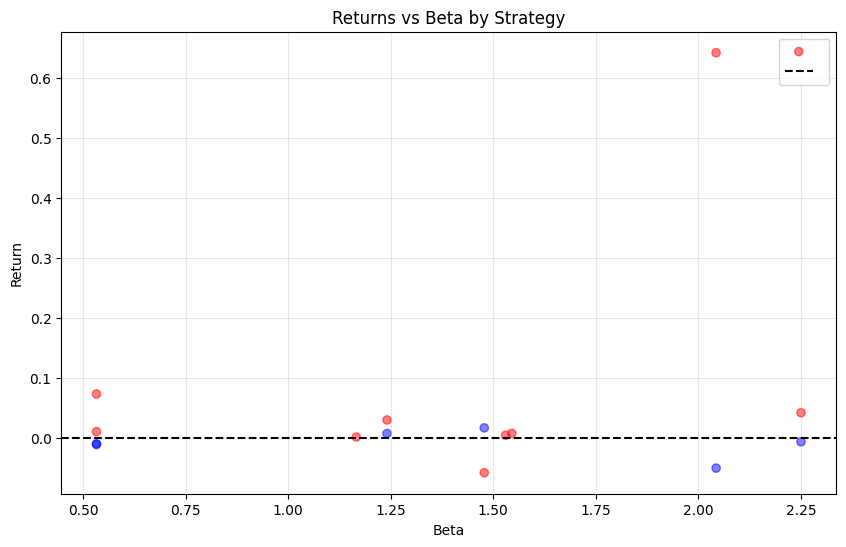

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(
    symbol_perf['Beta'], 
    symbol_perf['Return'],
    alpha=0.5, 
    c=symbol_perf['Strategy'].map({'Pre-Earnings': 'blue', 'Post-Earnings': 'red'})
)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Beta')
plt.ylabel('Return')
plt.title('Returns vs Beta by Strategy')
plt.legend(['', '', 'Pre-Earnings', 'Post-Earnings'])
plt.grid(True, alpha=0.3)
plt.show()

f:\Coding\Trading
f:\Coding\Trading\earnings

=== Preparing Data for Modular Analysis ===
Data prepared. Running modular analysis...


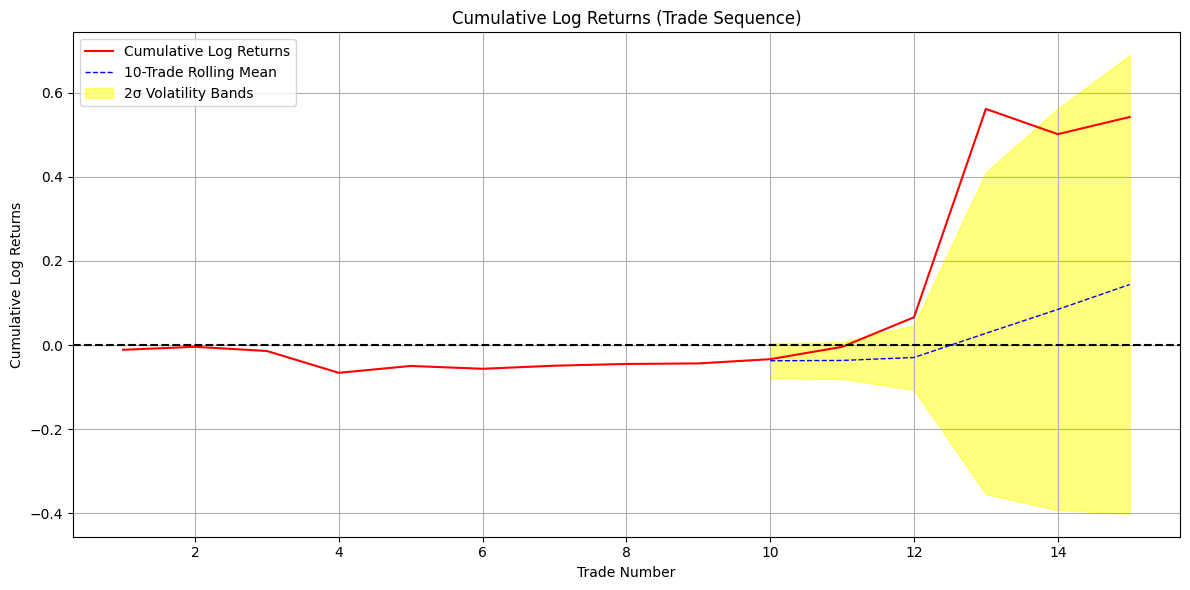

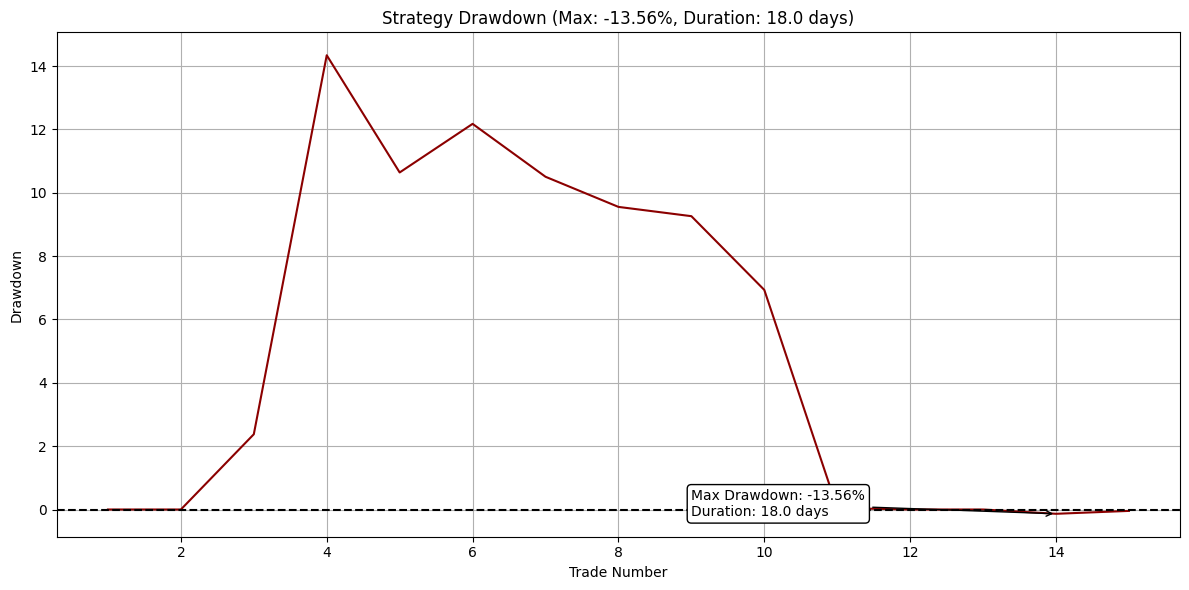

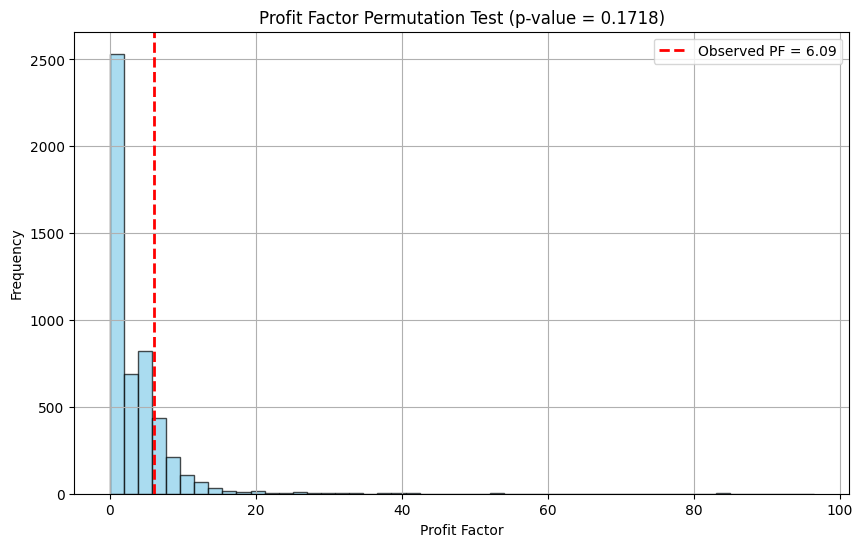


=== Profit Factor Permutation Test ===
Observed Profit Factor: 6.0881
Mean Permutation Profit Factor: 3.3585
P-value: 0.1718
Result: The observed profit factor is NOT statistically significant (p >= 0.05)

Final Profit Factor Permutation Test p-value: 0.1718

--- Return Statistics ---
count    15.0000
mean      0.0464
std       0.1677
min      -0.0582
10%      -0.0348
25%      -0.0083
50%       0.0071
75%       0.0231
90%       0.0604
99%       0.5618
99.9%     0.6334
99.99%    0.6406
max       0.6414

--- Worst Outcomes (Bottom 5.0%) ---
Worst 5.0000%: -0.0529
Worst 0.5000%: -0.0577
Worst 0.0500%: -0.0582


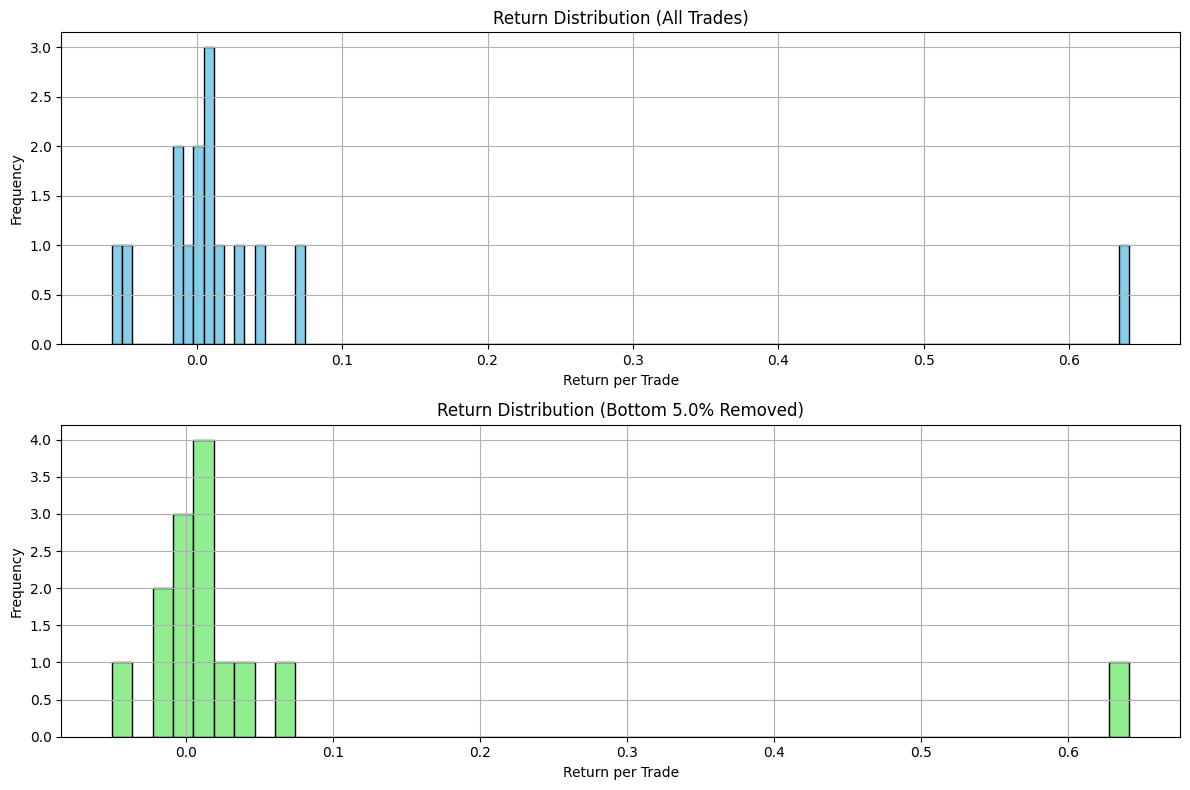


--- Full Dataset Kelly Simulations ---

Kelly Fraction: 100%
count    5000.00
mean     1986.64
std      1376.29
min       688.66
1%        823.42
10%       980.33
25%      1122.70
50%      1664.23
75%      2425.97
90%      3163.66
99%      7553.23
max     27912.94


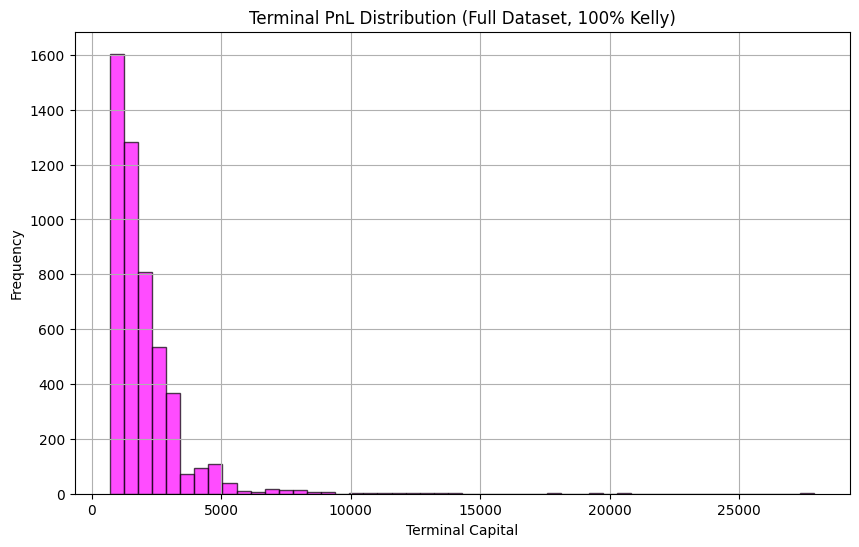

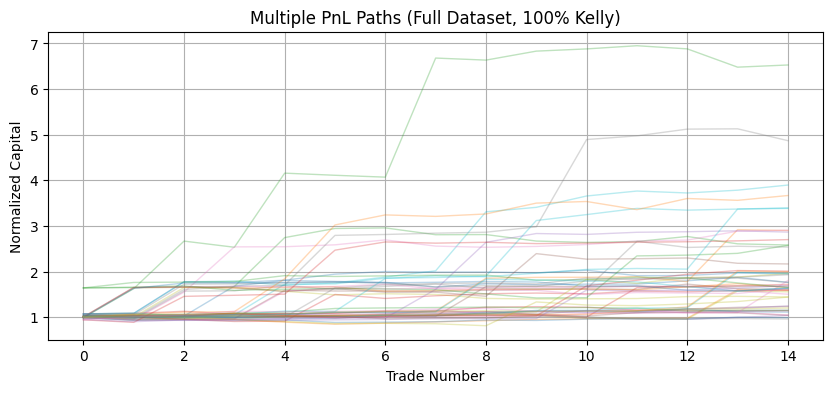


Kelly Fraction: 50%
count   5000.00
mean    1413.50
std      453.92
min      832.25
1%       909.00
10%      991.76
25%     1061.67
50%     1331.92
75%     1656.24
90%     1893.73
99%     3105.82
max     6541.16


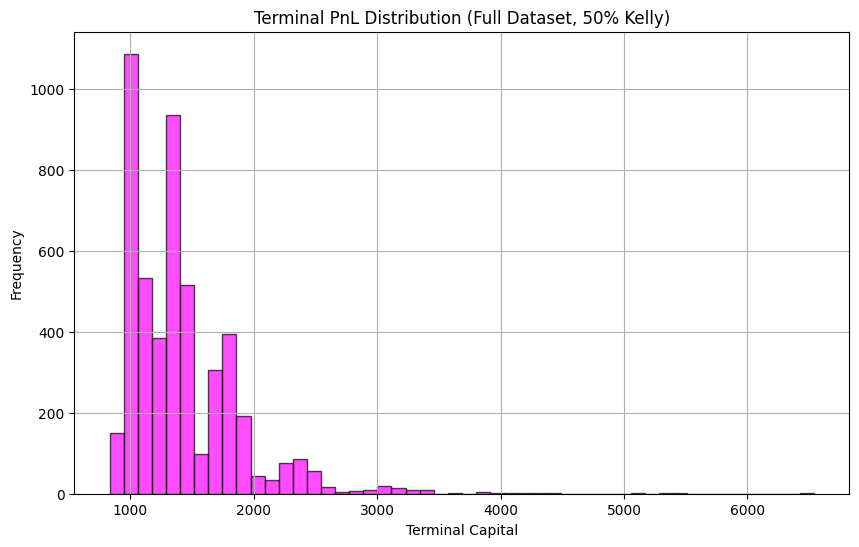

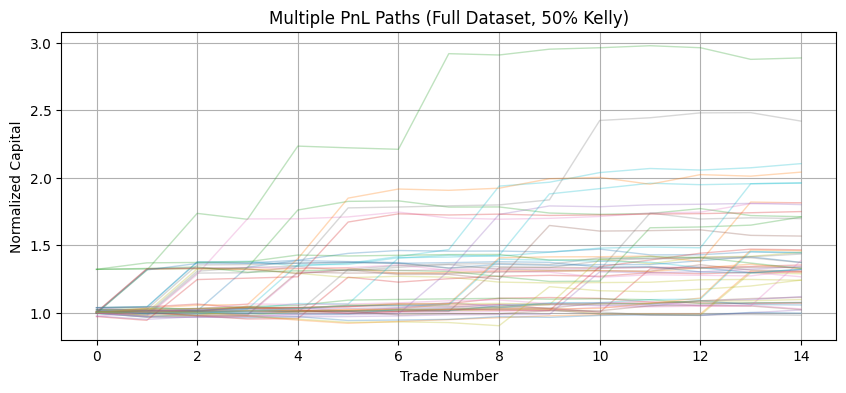


Kelly Fraction: 30%
count   5000.00
mean    1231.72
std      234.14
min      896.28
1%       944.75
10%      995.37
25%     1037.14
50%     1198.97
75%     1378.81
90%     1494.59
99%     2047.24
max     3289.33


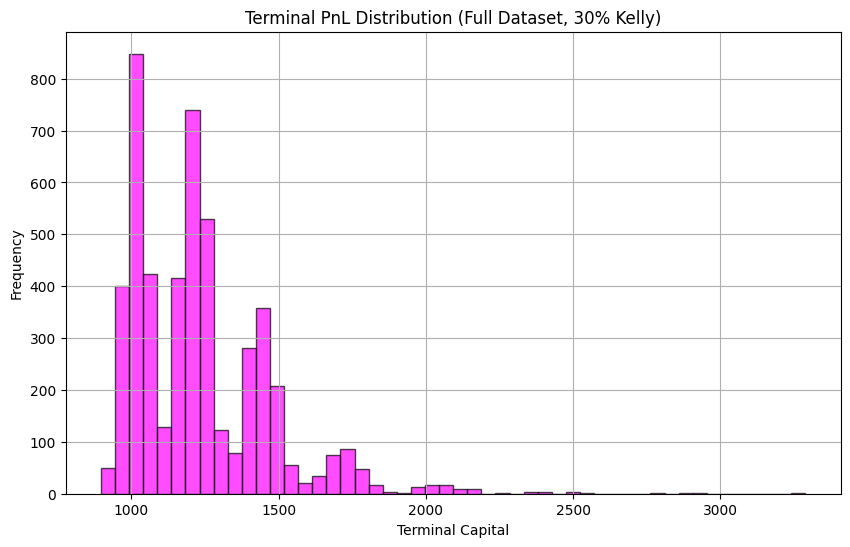

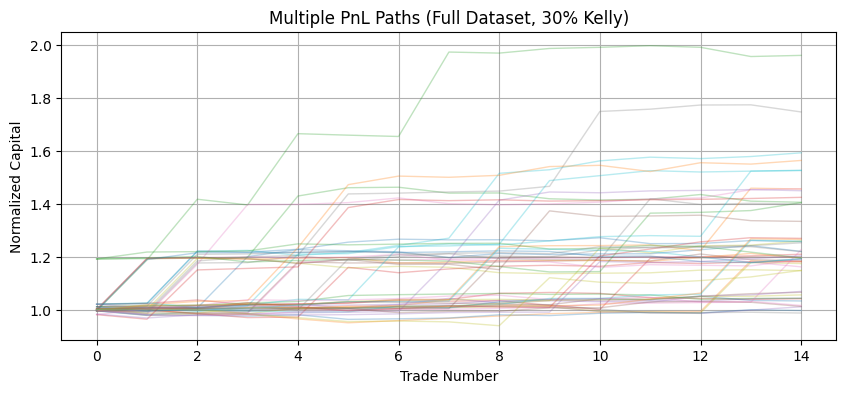

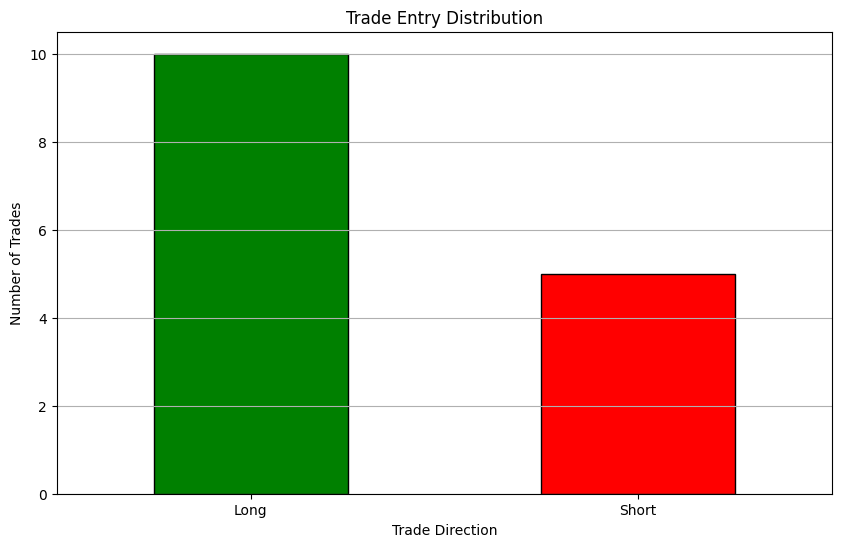

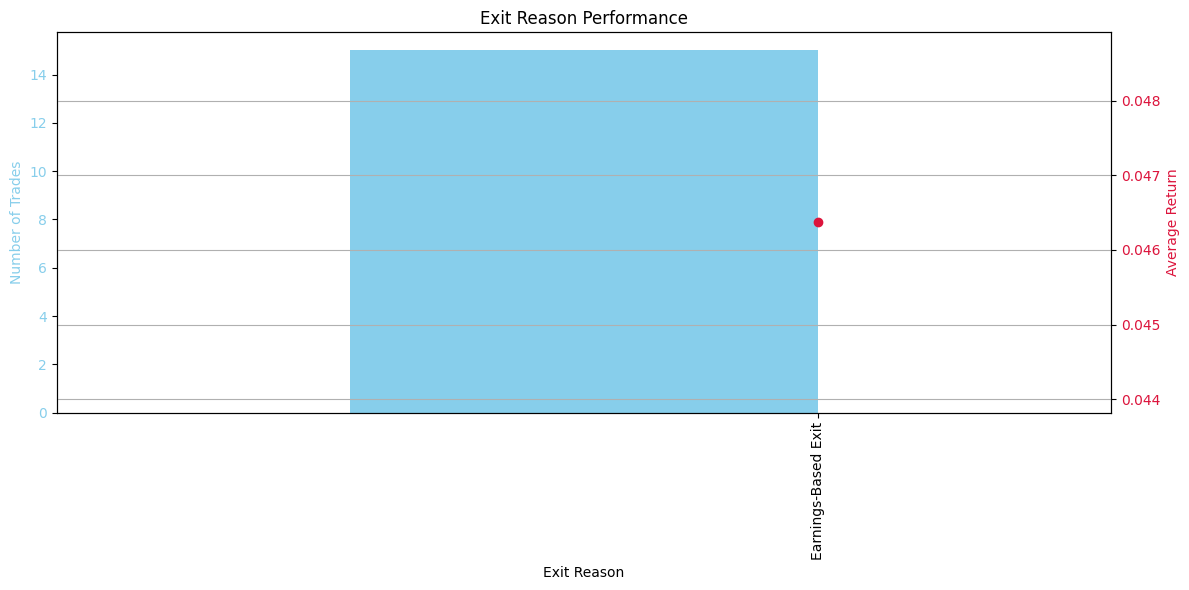


--- Trade Direction Summary ---
Direction
Long     10
Short     5

--- Exit Reason Performance ---
                    Count Avg Return
Exit Reason                         
Earnings-Based Exit    15     0.0464

=== Modular Analysis Complete ===


In [17]:
%cd ..
from graphs import (
    plot_cumulative_returns,
    plot_drawdown,
    perform_profit_factor_permutation_test,
    plot_return_distribution,
    plot_kelly_criterion_analysis,
    plot_trade_direction_and_exit_analysis
)
%cd earnings

# Make sure results is not empty before performing analysis
if not results.empty:
    print("\n=== Preparing Data for Modular Analysis ===")
    
    # Create a copy to avoid modifying the original
    results_for_analysis = results.copy()
    
    # --- CRITICAL: Align column names with the modular functions ---
    # The new graphs expect 'DateTime' for entry and 'Exit Time' for exit.
    results_for_analysis.rename(columns={
        'Entry Date': 'DateTime',
        'Exit Date': 'Exit Time'
    }, inplace=True)
    
    # --- CRITICAL: Convert to proper datetime format ---
    results_for_analysis['DateTime'] = pd.to_datetime(results_for_analysis['DateTime'])
    results_for_analysis['Exit Time'] = pd.to_datetime(results_for_analysis['Exit Time'])
    
    # --- CRITICAL: Add 'Exit Reason' column for compatibility ---
    # Since your strategy doesn't have complex exits, use a generic reason.
    results_for_analysis['Exit Reason'] = 'Earnings-Based Exit'
    
    print("Data prepared. Running modular analysis...")
    
    # Now call the individual modular functions
    # 1. Cumulative Returns
    plot_cumulative_returns(results_for_analysis, rolling_window=10)  # Adjusted for potentially fewer trades
    
    # 2. Drawdown
    plot_drawdown(results_for_analysis)
    
    # 3. Profit Factor Permutation Test
    p_value = perform_profit_factor_permutation_test(results_for_analysis['Return'].values, n_permutations=5000)
    print(f"\nFinal Profit Factor Permutation Test p-value: {p_value:.4f}")
    
    # 4. Return Distribution
    plot_return_distribution(results_for_analysis, zoom_percentile=0.05)  # Adjusted zoom level
    
    # 5. Kelly Criterion Analysis (Simplified for event-based strategies)
    # Define a custom time window since 'Full Dataset' is most relevant
    custom_windows = [('Full Dataset', None)]
    plot_kelly_criterion_analysis(
        results_for_analysis,
        time_windows=custom_windows,
        kelly_fractions=[1.0, 0.5, 0.3]
    )
    
    # 6. Trade Direction and Exit Analysis
    plot_trade_direction_and_exit_analysis(results_for_analysis)
    
    print("\n=== Modular Analysis Complete ===")
else:
    print("No trades found with the given strategy.")